In [63]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import numpy as np
%matplotlib inline
import pickle

In [200]:
# Packages from fire_pytools
from utils.monthly_date import *

from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios

desired_width = 10
pd.set_option('display.width', desired_width)
idx = pd.IndexSlice

# Annual Data and Monthly Data
f_a = open('../output/stock_annual.pkl','rb')  
adata = pickle.load(f_a)
f_m = open('../output/stock_monthly.pkl','rb')  
mdata = pickle.load(f_m)  

In [201]:
# Set names
adata.drop(columns='inv', inplace=True)
adata.rename(columns={'mesum_june': 'me', 'inv_gvkey': 'inv'}, inplace=True) 

# %% Create Filters
# shrcd must be (10,11)
# ---------------------
print('Data deleted due to shrcd: %f' % np.round((1-adata.shrcd.isin([10, 11]).mean())*100, 2))
sort_data = adata[adata.shrcd.isin([10, 11])].copy()

# exchcd must be (1, 2, 3)
# ------------------------
print('Data deleted due to exchcd: %f' % np.round((1-sort_data.exchcd.isin([1, 2, 3]).mean())*100, 2))
sort_data = sort_data[sort_data.exchcd.isin([1, 2, 3])]


#del adata, mdata

# %% Portfolio Sorts
## ME X BEME
# notice that the way we defined beme or beme is null if be<=0
sample_filters = ((sort_data.me > 0) &
                  (sort_data.mesum_dec > 0) &
                  (sort_data.beme.notnull()))

beme_sorts = sort_portfolios(data=sort_data[sample_filters],
                             quantiles={'me': [0.5], 'beme': [0.3, 0.7]},
                             id_variables=['rankyear', 'permno', 'exchcd'],
                             exch_cd=[1]
                             )

# TODO: ME X OP 30th and 70th percentiles for BEME, OP and INV.
sample_filters_meop = ((sort_data.me > 0) &
                  (sort_data.mesum_dec > 0) &
                       (sort_data.be > 0) &
                  (sort_data.op.notnull()))

opbe_sorts = sort_portfolios(data=sort_data[sample_filters_meop],
                             quantiles={'me': [0.5], 'opbe': [0.3, 0.7]},
                             id_variables=['rankyear', 'permno', 'exchcd'],
                             exch_cd=[1]
                             )
# TODO: ME X INV 
sample_filters_meinv = ((sort_data.me > 0) &
                  (sort_data.mesum_dec > 0) &
                  (sort_data.inv.notnull()))

inv_sorts = sort_portfolios(data=sort_data[sample_filters_meinv],
                             quantiles={'me': [0.5], 'inv': [0.3, 0.7]},
                             id_variables=['rankyear', 'permno', 'exchcd'],
                             exch_cd=[1])

Data deleted due to shrcd: 23.320000
Data deleted due to exchcd: 1.560000
NYSE breakpoints were calculated for me.
Stocks were sorted according to breakpoints, starting in 1926.0
NYSE breakpoints were calculated for beme.
Stocks were sorted according to breakpoints, starting in 1926.0
NYSE breakpoints were calculated for me.
Stocks were sorted according to breakpoints, starting in 1951.0
NYSE breakpoints were calculated for opbe.
Stocks were sorted according to breakpoints, starting in 1951.0
NYSE breakpoints were calculated for me.
Stocks were sorted according to breakpoints, starting in 1952.0
NYSE breakpoints were calculated for inv.
Stocks were sorted according to breakpoints, starting in 1952.0


# Stock Monthly Questions

## Question 1

In [10]:
mdata['yeara'] = pd.DatetimeIndex(mdata['date']).year
mdata['month'] = pd.DatetimeIndex(mdata['date']).month

In [13]:
mdata_Dec_2019 = mdata[(mdata['yeara'] == 2019) & (mdata['month'] == 12)]

In [20]:
len(mdata_Dec_2019['permno'].unique())

7595

In [15]:
mdata_Dec_2019['cret'].agg(['mean','min','max'])

mean     0.164604
min     -0.999424
max     12.960993
Name: cret, dtype: float64

In [16]:
mdata_Dec_2019.isnull().sum(axis=0)

index              0
date               0
permno             0
dlret           7543
dlretx          7543
exchcd             0
naics             39
permco             0
prc               61
ret               62
shrcd              0
shrout             0
siccd             25
ticker             0
retadj            10
me                61
mesum_permco      46
mesum           7595
days_diff          0
melag           7595
cret             536
rankyear           0
yeara              0
month              0
dtype: int64

## Question 2

List the top 10 firms that had the highest 11-months performance returns as December 2019.

In [99]:
import warnings
warnings.filterwarnings("ignore")
mdata_Dec_2019.sort_values(['cret'],ascending=False,inplace=True)

In [100]:
mdata_Dec_2019.head(10)[['permno','cret']]

,permno,cret
256135,15831,12.960993
311315,17958,10.610972
309894,17880,7.423445
1332245,89289,5.486487
803629,80069,4.878422
311797,17973,4.627119
274716,16524,4.464417
285336,16932,4.234008
258608,15914,4.208334
244193,15496,4.195531


## Question 3

List the top 10 firms that had the lowest 11-months performance returns as December 2019.

In [101]:
mdata_Dec_2019.sort_values(['cret'],ascending=True,inplace=True)
mdata_Dec_2019.head(10)[['permno','cret']]

,permno,cret
1661992,92571,-0.999424
264775,16112,-0.991961
989963,84302,-0.988659
202036,14610,-0.986897
273337,16469,-0.985842
266970,16173,-0.965919
239247,15375,-0.961913
309511,17854,-0.960798
239471,15381,-0.953462
1442143,90298,-0.953426


# Stock Annual Questions

## Question 4

Calculate a time series of the value spread between the value stocks (top BEME bucket) and the growth stocks (bottom BEME bucket). The BEME value of each bucket should be calculated as the log of ratio of the sum of BE of all stocks in the bucket and the sum of ME of all stocks in the bucket.

In [186]:
df_value_growth = pd.merge(adata[['rankyear','be','me','permno']],beme_sorts,on = ['rankyear','permno'])
cal_value_spread = df_value_growth.groupby(['rankyear','bemeportfolio']).sum()
cal_value_spread['log_ratio'] = np.log(cal_value_spread['be'] / cal_value_spread['me'])
cal_value_spread.reset_index(inplace = True)
cal_value_spread['beme_spread'] = cal_value_spread['log_ratio'].diff(2)
res_value_spread = cal_value_spread[cal_value_spread['bemeportfolio'] == 'beme3']

In [187]:
res_value_spread.set_index(["rankyear"], inplace=True)

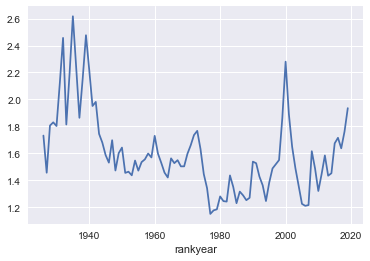

In [188]:
res_value_spread['beme_spread'].plot()

Question: Based on your plot, what is your best guess for the performance of value-minus-growth strategies in the last 10 years?

In the last ten years, the value spread increased smoothly which indicated that the performance of value-minus-growth would also increase smoothly.

## Question 5

Analogous to the value spread, calculate the profitability spread and the investment spread. Report a plot with the 3 time series plots.

### profitability spread

In [233]:
df_opbe = pd.merge(adata[['rankyear','op','be','permno','opbe']],opbe_sorts,on = ['rankyear','permno'])
cal_profit_spread = df_opbe.groupby(['rankyear','opbeportfolio']).sum()
cal_profit_spread['ratio'] = cal_profit_spread['op'] / cal_profit_spread['be']
cal_profit_spread.reset_index(inplace = True)
cal_profit_spread['opbe_spread'] = cal_profit_spread['ratio'].diff(2)
res_profit_spread = cal_profit_spread[cal_profit_spread['opbeportfolio'] == 'opbe3']

In [234]:
res_profit_spread.set_index(["rankyear"], inplace=True)

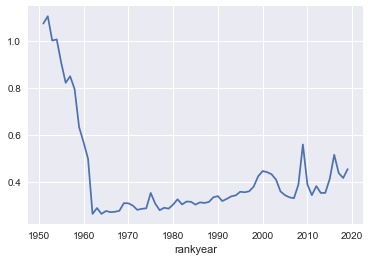

In [235]:
res_profit_spread['opbe_spread'].plot()

### investment spread

In [192]:
df_inv = pd.merge(adata[['rankyear','be','me','permno','inv']],inv_sorts,on = ['rankyear','permno'])
cal_inv_spread  = df_inv.groupby(['rankyear','invportfolio']).mean()

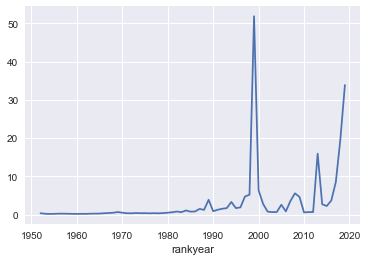

In [193]:
cal_inv_spread .reset_index(inplace = True)
cal_inv_spread ['inv_spread'] = cal_inv_spread ['inv'].diff(2)
res_inv_spread = cal_inv_spread [cal_inv_spread ['invportfolio'] == 'inv3']
res_inv_spread.set_index(["rankyear"], inplace=True)
res_inv_spread['inv_spread'].plot()

In [236]:
res_value_spread['opbe_spread'] = res_profit_spread['opbe_spread']
res_value_spread['inv_spread'] = res_inv_spread['inv_spread']

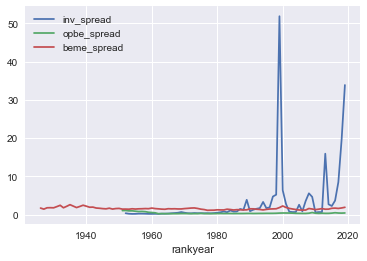

In [237]:
res_value_spread[['inv_spread','opbe_spread','beme_spread']].plot()